# Using SHAP values and IntegratedGradients for cell type classification interpretability

Previously we saw semi-supervised models, like SCANVI being used for tasks like cell type classification, enabling researchers to uncover complex biological patterns. However, as these models become more sophisticated, it is essential to understand not just the predictions they make, but why they make them. This is where interpretability methods like [SHAP (SHapley Additive exPlanations)](https://shap.readthedocs.io/en/latest/generated/shap.DeepExplainer.html#shap.DeepExplainer) and [CAPTUM IntegratedGradients](https://captum.ai/api/integrated_gradients.html) come into play. By providing insights into the influence of individual features on model predictions, these methods help us trust and validate our models in critical biological contexts. 

In this tutorial, we'll explore the significance of interpretability techniques in supervised cell classification using ScanVI, which are now avialble as part of SCVI-Tools. 

```{note}
Running the following cell will install tutorial dependencies on Google Colab only. It will have no effect on environments other than Google Colab.
```

In [1]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

/home/access/.conda/envs/scvi/lib/python3.12/site-packages/scvi_colab/_core.py:41: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import scvi
import seaborn as sns
import torch

torch.set_float32_matmul_precision("high")

## Load data and train scanvi

In this tutorial we will be using the dataset of peripheral blood mononuclear cells from 10x Genomics, [PBMC dataset](https://docs.scvi-tools.org/en/stable/api/reference/scvi.data.pbmc_dataset.html#scvi.data.pbmc_dataset)

In [3]:
adata = scvi.data.pbmc_dataset()
adata.layers["counts"] = adata.X.copy()
adata.obs["batch"] = adata.obs["batch"].astype("category")
adata

INFO     File data/gene_info_pbmc.csv already downloaded                                                           
INFO     File data/pbmc_metadata.pickle already downloaded                                                         
INFO     File data/pbmc8k/filtered_gene_bc_matrices.tar.gz already downloaded                                      
INFO     Extracting tar file                                                                                       
INFO     Removing extracted data at data/pbmc8k/filtered_gene_bc_matrices                                          
INFO     File data/pbmc4k/filtered_gene_bc_matrices.tar.gz already downloaded                                      
INFO     Extracting tar file                                                                                       
INFO     Removing extracted data at data/pbmc4k/filtered_gene_bc_matrices                                          


/home/access/.conda/envs/scvi/lib/python3.12/site-packages/scvi/data/_built_in_data/_pbmc.py:75: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = pbmc8k.concatenate(pbmc4k)


AnnData object with n_obs × n_vars = 11990 × 3346
    obs: 'n_counts', 'batch', 'labels', 'str_labels'
    var: 'gene_symbols', 'n_counts-0', 'n_counts-1', 'n_counts'
    uns: 'cell_types'
    obsm: 'design', 'raw_qc', 'normalized_qc', 'qc_pc'
    layers: 'counts'

In [4]:
adata.var_names = adata.var["gene_symbols"]

In [5]:
adata.obs.str_labels.value_counts()  # list of classes and their observations

str_labels
CD4 T cells          4996
CD14+ Monocytes      2227
B cells              1621
CD8 T cells          1448
Other                 463
NK cells              457
FCGR3A+ Monocytes     351
Dendritic Cells       339
Megakaryocytes         88
Name: count, dtype: int64

In [6]:
print("# cells, # genes before filtering:", adata.shape)

sc.pp.filter_genes(adata, min_counts=3)
sc.pp.filter_cells(adata, min_counts=3)

# cells, # genes before filtering: (11990, 3346)


In [7]:
# We select a small number of genes here, so our later interpretability analysis will be fast
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=200,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
    batch_key="batch",
)
print("# cells, # genes after filtering:", adata.shape)

# cells, # genes after filtering: (11990, 200)


In [8]:
scvi.model.SCANVI.setup_anndata(
    adata,
    layer="counts",
    batch_key="batch",
    labels_key="str_labels",
    unlabeled_category="unknown",
)

In [9]:
model = scvi.model.SCANVI(adata)
model

ScanVI Model with the following params: 
unlabeled_category: unknown, n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, 
gene_likelihood: zinb
Training status: Not Trained
Model's adata is minified?: False

In [10]:
model.train(
    max_epochs=100,
    early_stopping=True,
    check_val_every_n_epoch=1,
    train_size=0.8,
    validation_size=0.2,
    # accelerator="gpu",
    # devices=-1,
    # strategy="ddp_notebook_find_unused_parameters_true",
)

INFO     Training for 100 epochs.                                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/access/.conda/envs/scvi/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.
/home/access/.conda/envs/scvi/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


## Inspect scanvi training and test performance

In [11]:
adata.obsm["X_scANVI"] = model.get_latent_representation()

In [12]:
# use scVI latent space for UMAP generation
sc.pp.neighbors(adata, use_rep="X_scANVI", n_neighbors=30)

In [13]:
sc.tl.umap(adata, min_dist=0.3)

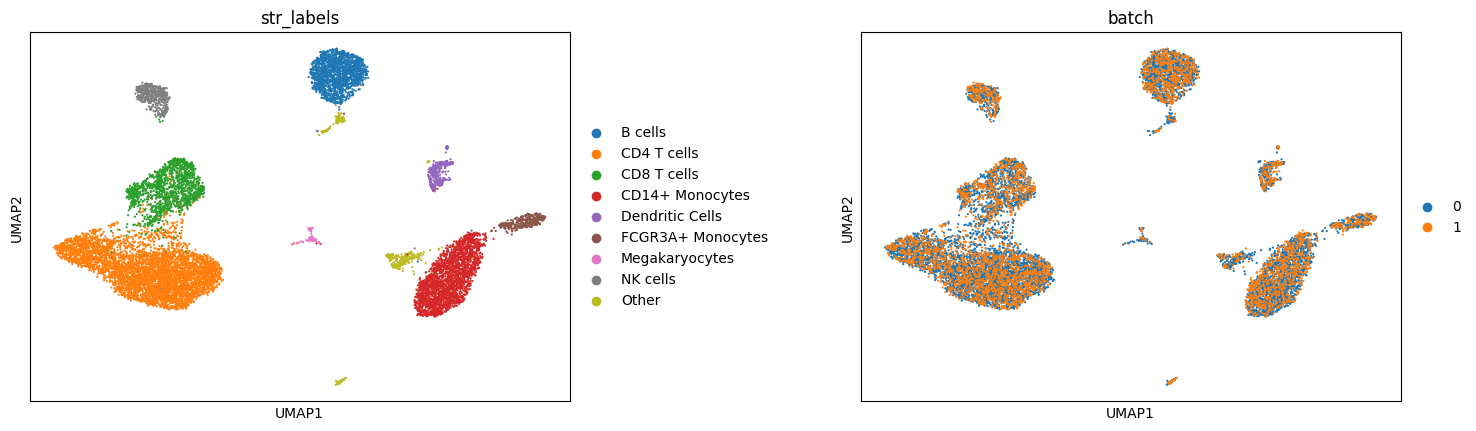

In [14]:
sc.pl.umap(adata, color=["str_labels", "batch"], ncols=2, wspace=0.4)

Next we will apply the 2 techniques for features interpretability and compare between them

## Integrated Gradients

Integrated Gradients is a robust interpretability technique that attributes the output of a model to its input features by calculating the cumulative sum of gradients along a path from a baseline (typically zero or a neutral input) to the actual input. This approach provides a way to measure how each feature contributes to the model's output in a smooth and consistent manner.

It is availble for any semi supervised model in SCVI-Tools by passing the ig_interpretability=True flag to the predict function.

In [15]:
predictions, attributions = model.predict(ig_interpretability=True)

The method works relatievely fast and we can then plot the gene table with their importnace mean and variance, overall for all cell - types

In [16]:
n_plot = 15
attributions.head(n_plot)

,gene,gene_idx,attribution_mean,attribution_std,cells
0,CD74,70,1.046176,4.104647,11990
1,IL32,148,0.810820,1.358012,11990
2,S100A6,17,0.756088,1.103666,11990
3,S100A9,15,0.716369,1.809122,11990
4,NKG7,186,0.702932,2.459903,11990
5,LTB,78,0.692312,1.575437,11990
6,TYROBP,179,0.683626,1.525760,11990
7,CST3,166,0.441730,1.180127,11990
8,FCN1,104,0.354472,0.991154,11990
9,MNDA,20,0.329743,0.744831,11990


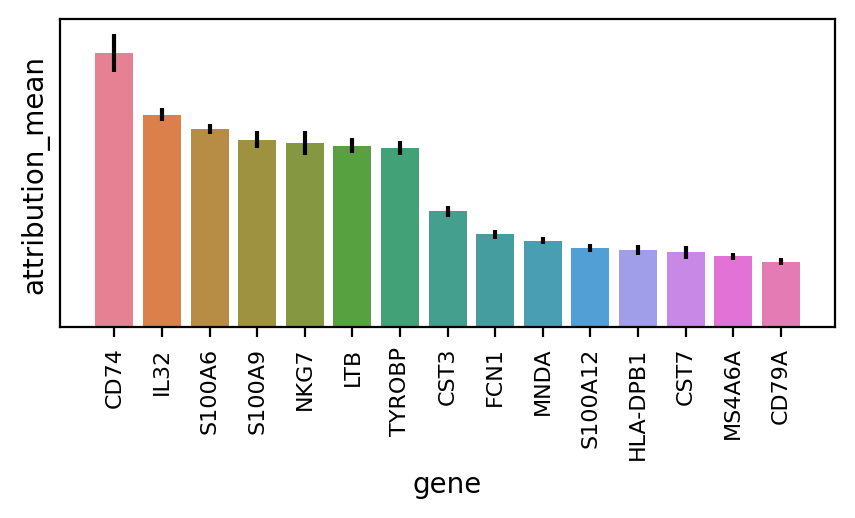

In [17]:
df = attributions.head(n_plot)
ci = 1.96 * df["attribution_std"] / np.sqrt(df["cells"])
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 2), dpi=200)
sns.barplot(ax=ax, data=df, x="gene", y="attribution_mean", hue="gene", dodge=False)
ax.set_yticks([])
plt.tick_params(axis="x", which="major", labelsize=8, labelrotation=90)
ax.errorbar(
    df["gene"].values,
    df["attribution_mean"].values,
    yerr=ci,
    ecolor="black",
    fmt="none",
)
if ax.get_legend() is not None:
    ax.get_legend().remove()

We can repeat for specific class ('Dendritic Cells'):

In [18]:
predictions_class, attributions_class = model.predict(
    indices=np.where(adata.obs.str_labels == "Dendritic Cells")[0].tolist(),
    ig_interpretability=True,
)

In [19]:
attributions_class.head(n_plot)

,gene,gene_idx,attribution_mean,attribution_std,cells
0,CD74,70,5.473364,0.948142,339
1,FCER1A,21,3.630613,1.943166,339
2,HLA-DPB1,81,3.318439,0.631406,339
3,VIM,117,1.793772,0.506637,339
4,ANXA1,97,1.650854,0.695445,339
5,HLA-DMB,79,1.374406,0.584015,339
6,CLEC10A,157,1.342435,1.255666,339
7,HLA-DMA,80,1.158052,0.371506,339
8,COTL1,154,1.053837,0.387444,339
9,TYROBP,179,0.987148,0.421023,339


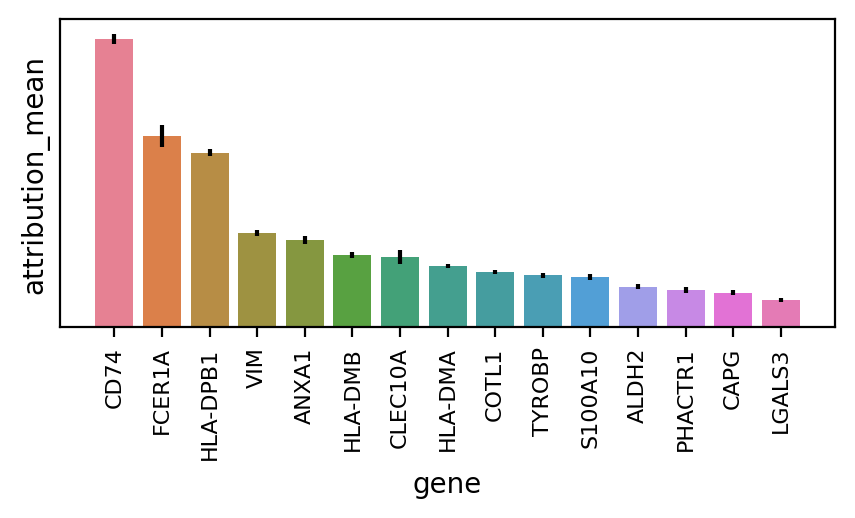

In [20]:
df_class = attributions_class.head(n_plot)
ci = 1.96 * df_class["attribution_std"] / np.sqrt(df_class["cells"])
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 2), dpi=200)
sns.barplot(ax=ax, data=df_class, x="gene", y="attribution_mean", hue="gene", dodge=False)
ax.set_yticks([])
plt.tick_params(axis="x", which="major", labelsize=8, labelrotation=90)
ax.errorbar(
    df_class["gene"].values,
    df_class["attribution_mean"].values,
    yerr=ci,
    ecolor="black",
    fmt="none",
)
if ax.get_legend() is not None:
    ax.get_legend().remove()

As expected, for a specific class, we can see different important genes, altough S100A4 is still the top contributer

More generally we would like to see a more general view of top genes to contribute to our celltype groups classification.

/tmp/ipykernel_1489080/979630081.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive["contribution"] = "positive"
/tmp/ipykernel_1489080/979630081.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative["contribution"] = "negative"
/tmp/ipykernel_1489080/979630081.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

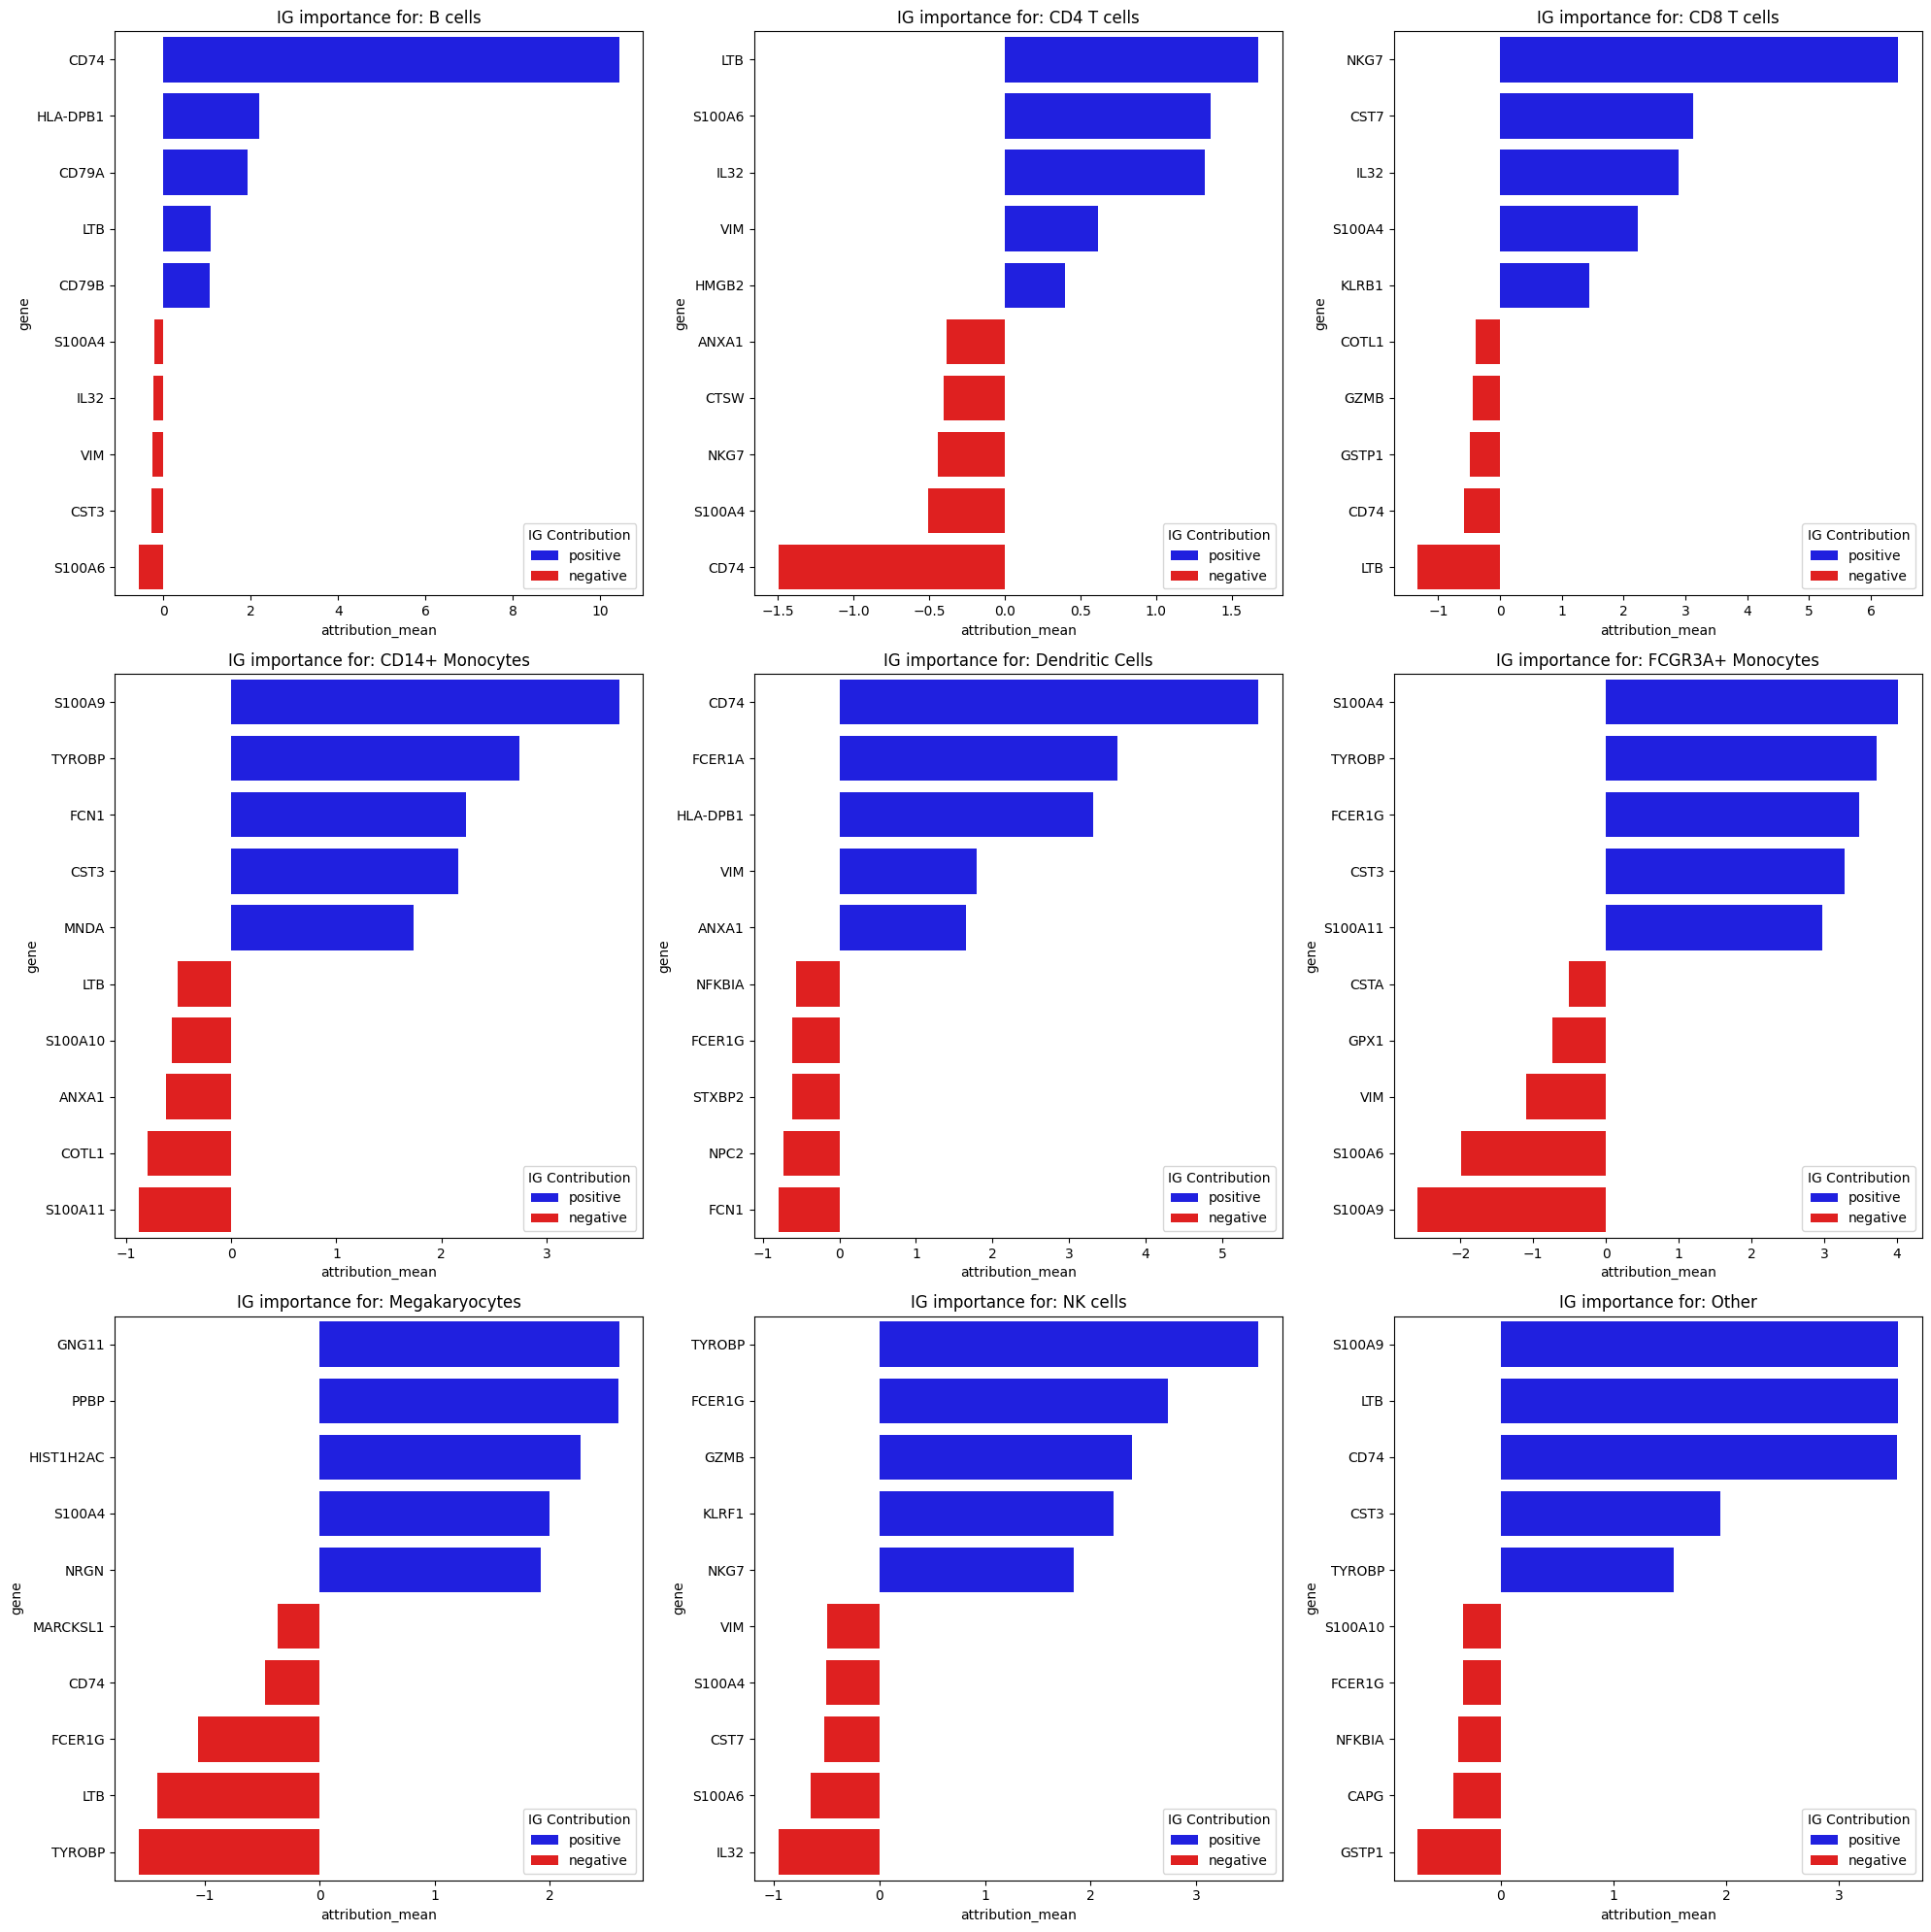

In [21]:
classes = adata.obs.str_labels.cat.categories
features = adata.var_names
attributions_class_pos_agg = pd.DataFrame()
n_cols = 3
top_n = 5
nrows = round(classes.size / n_cols)
fig, ax = plt.subplots(nrows, n_cols, sharex=False, figsize=(20, 20))
for idx, ct in enumerate(classes):
    _, attributions_class = model.predict(
        indices=np.where(adata.obs.str_labels == ct)[0].tolist(),
        ig_interpretability=True,
    )
    positive = attributions_class.head(top_n)
    positive["contribution"] = "positive"
    negative = attributions_class.tail(top_n)
    negative["contribution"] = "negative"
    avg = pd.concat([positive, negative])
    title = f"IG importance for: {ct}"

    # also keep the positive contributions
    attributions_class_pos = attributions_class[attributions_class.attribution_mean > 0]
    attributions_class_pos["class"] = ct
    attributions_class_pos_agg = pd.concat([attributions_class_pos_agg, attributions_class_pos])

    sns.barplot(
        x="attribution_mean",
        y="gene",
        hue="contribution",
        palette=["blue", "red"],
        data=avg,
        ax=ax[idx // n_cols, idx % n_cols],
    )

    ax[idx // n_cols, idx % n_cols].set_title(title)
    ax[idx // n_cols, idx % n_cols].legend(title="IG Contribution", loc="lower right")

_ = [fig.delaxes(ax_) for ax_ in ax.flatten() if not ax_.has_data()]

fig.tight_layout()

And we can also show the positive contribution of each gene being aggregated per cell type group

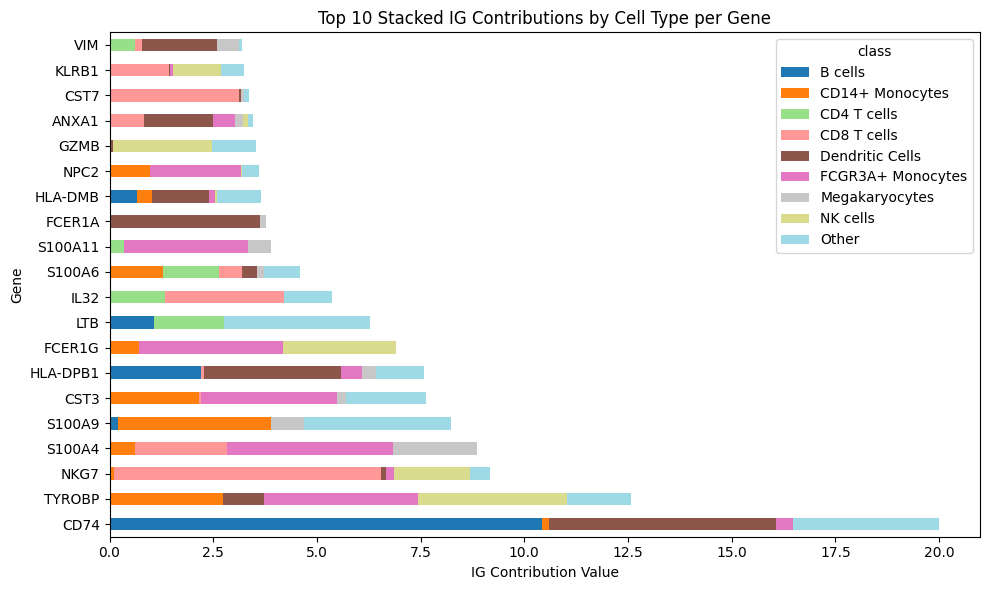

In [22]:
top_n = 20
# Pivot the data so that each group becomes a column for stacking
pivot_df = attributions_class_pos_agg.pivot_table(
    index="gene", columns="class", values="attribution_mean", aggfunc="sum"
)

# Sort by the total sum of each feature (sum across all groups)
pivot_df["total"] = pivot_df.sum(axis=1)  # Calculate the total sum for each feature
pivot_df = pivot_df.sort_values(by="total", ascending=False)  # Sort by the total value
pivot_df = pivot_df.head(top_n)  # Select the top 10 features

# Plotting the horizontal stacked bar plot
ax = pivot_df.drop("total", axis=1).plot(
    kind="barh", stacked=True, figsize=(10, 6), colormap="tab20"
)

# Add labels and title
ax.set_xlabel("IG Contribution Value")
ax.set_ylabel("Gene")
ax.set_title("Top 10 Stacked IG Contributions by Cell Type per Gene")

# Display the plot
plt.tight_layout()
plt.show()

## SHAP

SHAP (SHapley Additive exPlanations) values are a popular interpretability technique based on cooperative game theory. The core idea is to fairly allocate the "credit" for a model's prediction to each feature, by considering all possible combinations of features and their impact on the prediction. SHAP values are additive, meaning the sum of the SHAP values for all features equals the difference between the model’s output and the average prediction. This method works for any model type, providing a consistent way to explain individual predictions, making it highly versatile and widely applicable. Deep SHAP is an extension of the SHAP method designed specifically for deep learning models, such as the ones in SCVI-Tools. For more information see [this](https://www.nature.com/articles/s41592-024-02511-3)

Calcualtion of SHAP for SC data usually takes a lot of time. In SCVI-Tools we are running an approximation of FastSHAP in order to reduce runtime, where we train a shallow surrogate model to imitate the original model prediction and than run the SHAP over the surrogate model. See [this]("https://arxiv.org/abs/2107.07436")

In [23]:
import torch.nn as nn
from scvi.utils import FastSHAP, Surrogate
from scvi.utils.fastshap import KLDivLoss, MaskLayer1d

In [24]:
num_features = len(features)
num_classes = len(classes)
surr = nn.Sequential(
    MaskLayer1d(value=0, append=True),
    nn.Linear(2 * num_features, 128),
    nn.ELU(inplace=True),
    nn.Linear(128, 128),
    nn.ELU(inplace=True),
    nn.Linear(128, num_classes),
).to(model.device)

In [ ]:
# Set up surrogate object
surrogate = Surrogate(surr, num_features)
# Train Surrogate
surrogate.train_original_model(
    train_data=adata.X.toarray()[model.train_indices],
    val_data=adata.X.toarray()[model.validation_indices],
    original_model=model.shap_adata_predict,
    batch_size=64,
    max_epochs=10,
    loss_fn=KLDivLoss(),
    validation_samples=10,
    validation_batch_size=10000,
    verbose=True,
)

In [28]:
# Train FastSHAP
# Create explainer model
explainer = nn.Sequential(
    nn.Linear(num_features, 128),
    nn.ReLU(inplace=True),
    nn.Linear(128, 128),
    nn.ReLU(inplace=True),
    nn.Linear(128, num_classes * num_features),
).to(model.device)

In [29]:
# Set up FastSHAP object
fastshap = FastSHAP(explainer, surrogate, normalization="additive", link=nn.Softmax(dim=-1))
# Train
fastshap.train(
    train_data=adata.X.toarray()[model.train_indices],
    val_data=adata.X.toarray()[model.validation_indices],
    batch_size=32,
    num_samples=32,
    max_epochs=100,
    validation_samples=128,
    verbose=True,
)

----- Epoch = 1 -----
Val loss = 5.208660

New best epoch, loss = 5.208660

----- Epoch = 2 -----
Val loss = 1.557097

New best epoch, loss = 1.557097

----- Epoch = 3 -----
Val loss = 0.361534

New best epoch, loss = 0.361534

----- Epoch = 4 -----
Val loss = 0.076193

New best epoch, loss = 0.076193

----- Epoch = 5 -----
Val loss = 0.025957

New best epoch, loss = 0.025957

----- Epoch = 6 -----
Val loss = 0.017574

New best epoch, loss = 0.017574

----- Epoch = 7 -----
Val loss = 0.015273

New best epoch, loss = 0.015273

----- Epoch = 8 -----
Val loss = 0.014053

New best epoch, loss = 0.014053

----- Epoch = 9 -----
Val loss = 0.013188

New best epoch, loss = 0.013188

----- Epoch = 10 -----
Val loss = 0.012649

New best epoch, loss = 0.012649

----- Epoch = 11 -----
Val loss = 0.012275

New best epoch, loss = 0.012275

----- Epoch = 12 -----
Val loss = 0.012005

New best epoch, loss = 0.012005

----- Epoch = 13 -----
Val loss = 0.011791

New best epoch, loss = 0.011791

----- Ep

We repeat the same figure plot like the previous case:

/tmp/ipykernel_1489080/3161957804.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive["contribution"] = "positive"
/tmp/ipykernel_1489080/3161957804.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative["contribution"] = "negative"
/tmp/ipykernel_1489080/3161957804.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

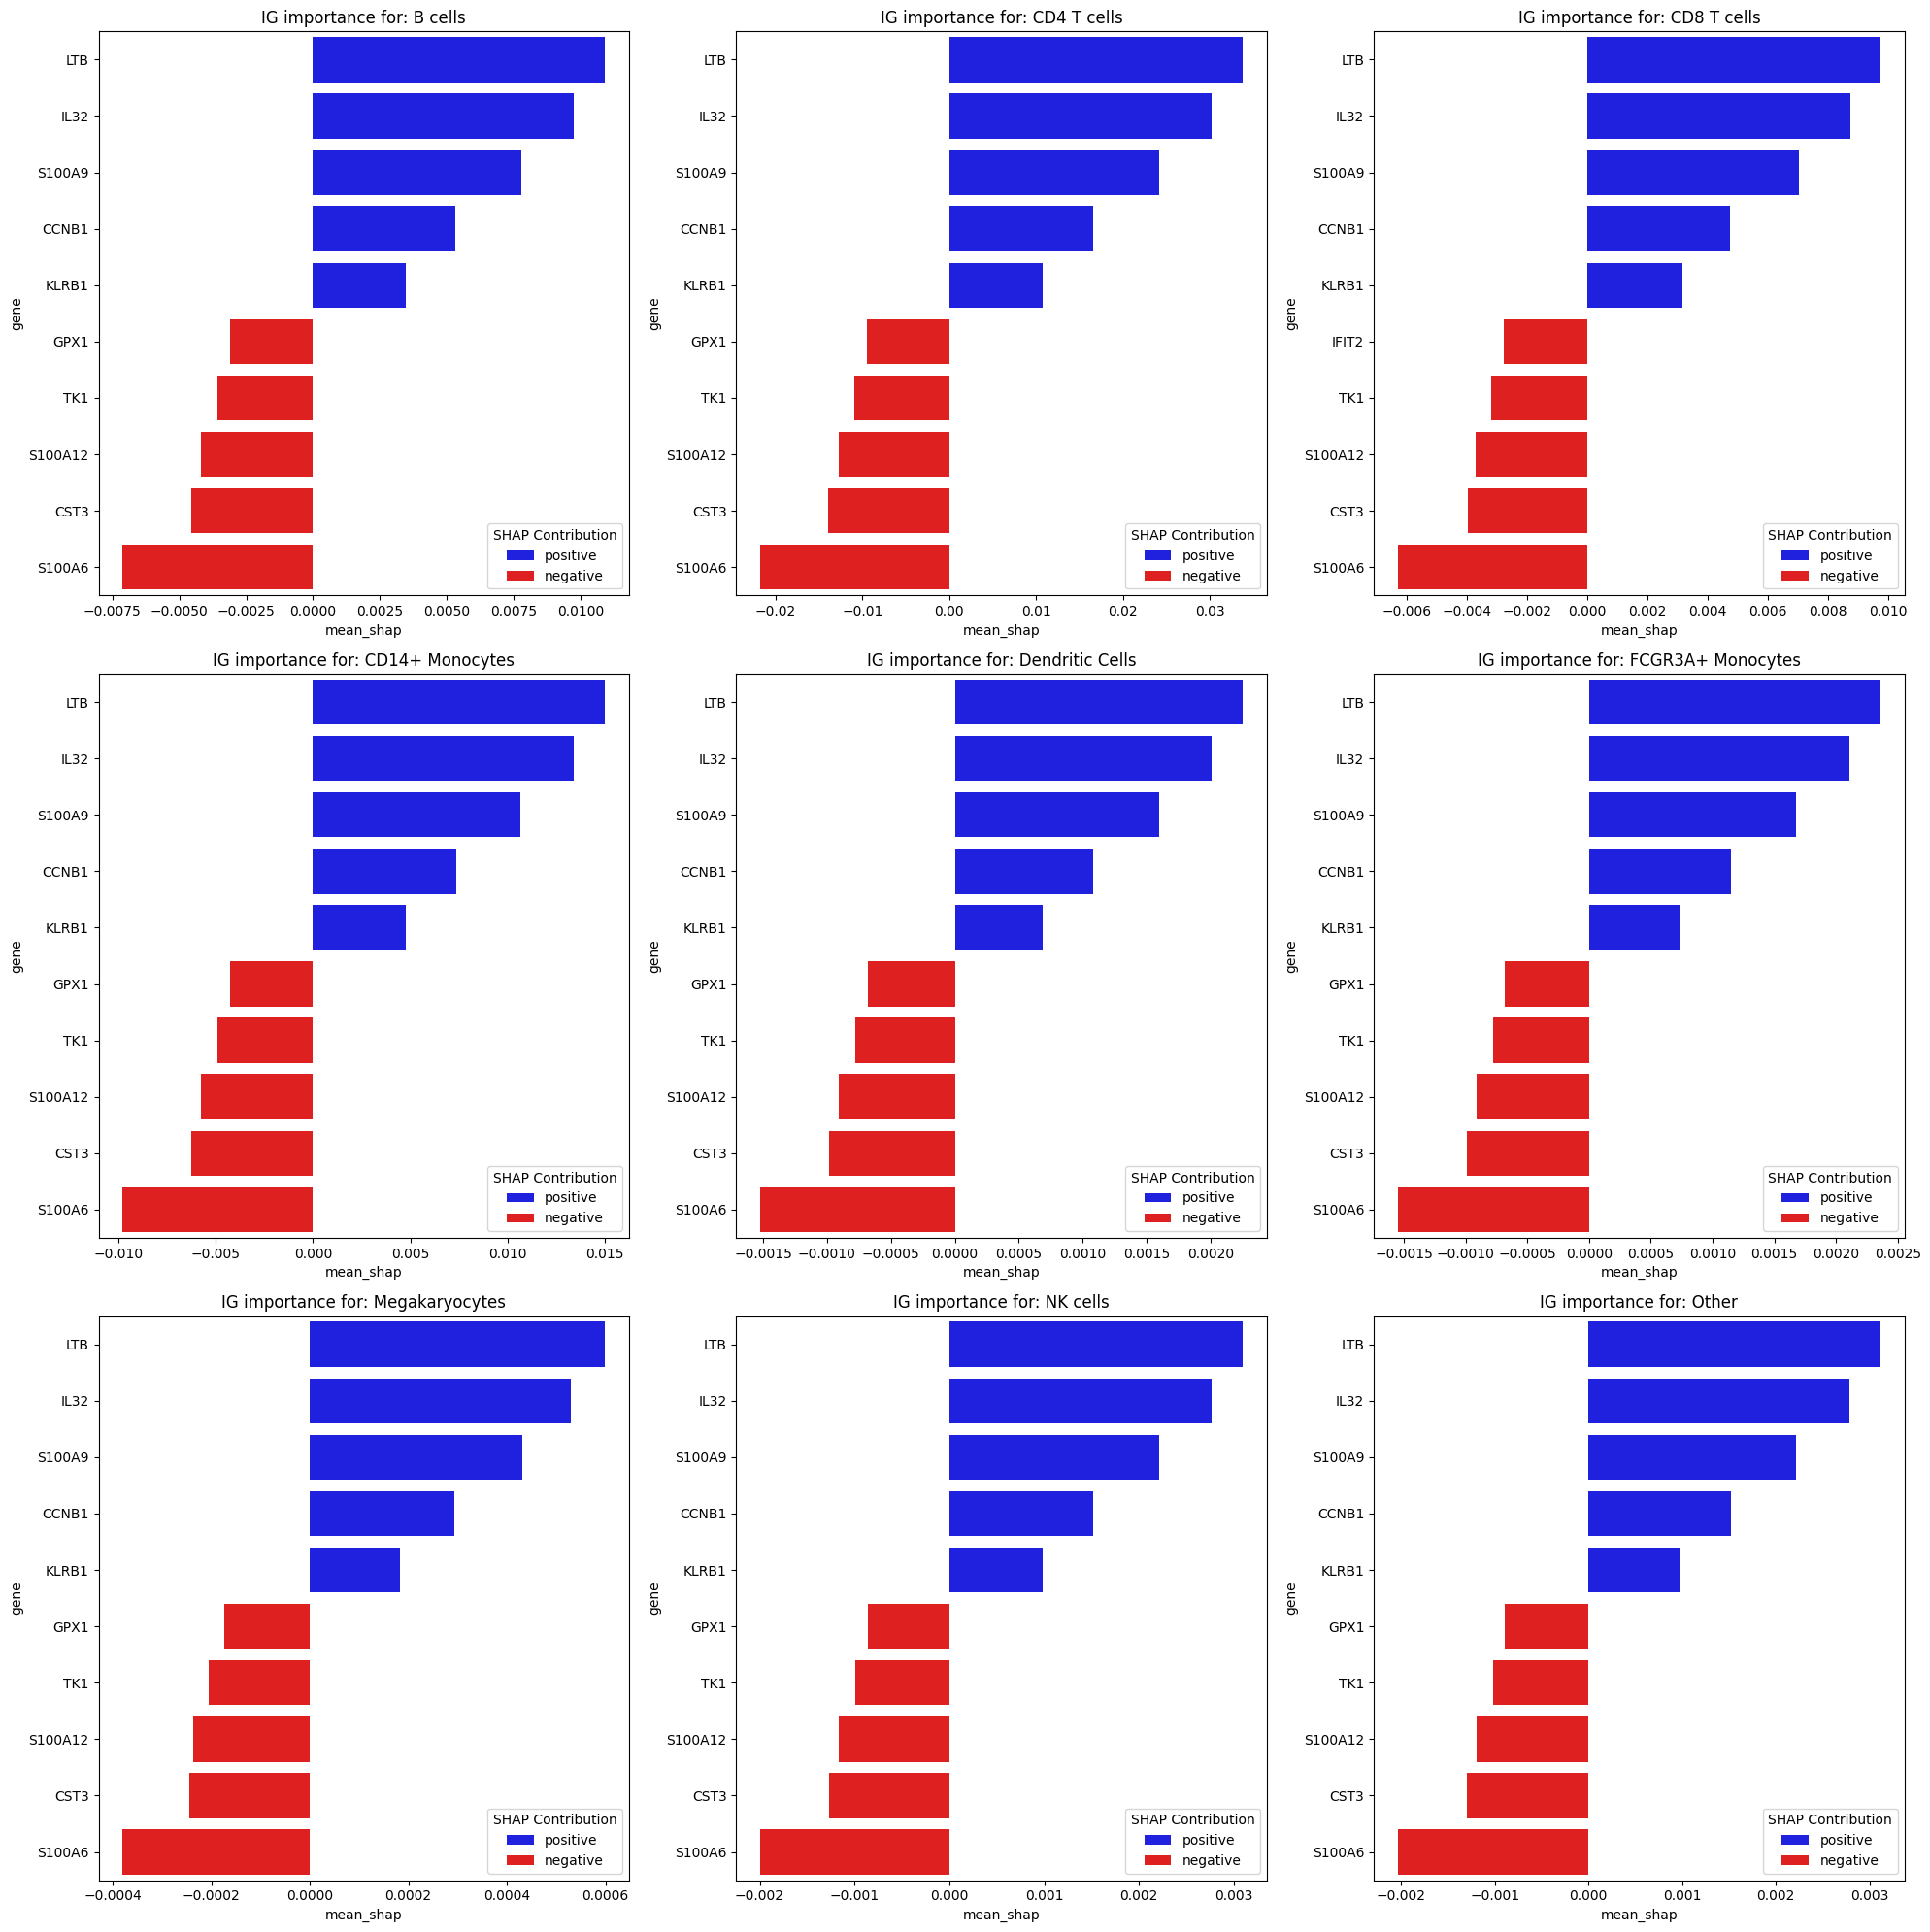

In [30]:
classes = adata.obs.str_labels.cat.categories
features = adata.var_names
attributions_class_pos_agg = pd.DataFrame()
n_cols = 3
top_n = 5
nrows = round(classes.size / n_cols)
fig, ax = plt.subplots(nrows, n_cols, sharex=False, figsize=(20, 20))
for idx, ct in enumerate(classes):
    sum_shap_per_class = [0] * num_features
    for ind in np.where(adata.obs.str_labels == ct)[0].tolist():
        sum_shap_per_class += fastshap.shap_values(np.array([adata.X[ind].toarray()]))[0][:, 0]
    attributions_class = pd.DataFrame(
        {"gene": features, "mean_shap": sum_shap_per_class / num_features, "class": ct}
    ).sort_values("mean_shap", ascending=False)

    positive = attributions_class.head(top_n)
    positive["contribution"] = "positive"
    negative = attributions_class.tail(top_n)
    negative["contribution"] = "negative"
    avg = pd.concat([positive, negative])
    title = f"IG importance for: {ct}"

    # also keep the positive contributions
    attributions_class_pos = attributions_class[attributions_class.mean_shap > 0]
    attributions_class_pos["class"] = ct
    attributions_class_pos_agg = pd.concat([attributions_class_pos_agg, attributions_class_pos])

    sns.barplot(
        x="mean_shap",
        y="gene",
        hue="contribution",
        palette=["blue", "red"],
        data=avg,
        ax=ax[idx // n_cols, idx % n_cols],
    )

    ax[idx // n_cols, idx % n_cols].set_title(title)
    ax[idx // n_cols, idx % n_cols].legend(title="SHAP Contribution", loc="lower right")

_ = [fig.delaxes(ax_) for ax_ in ax.flatten() if not ax_.has_data()]

fig.tight_layout()

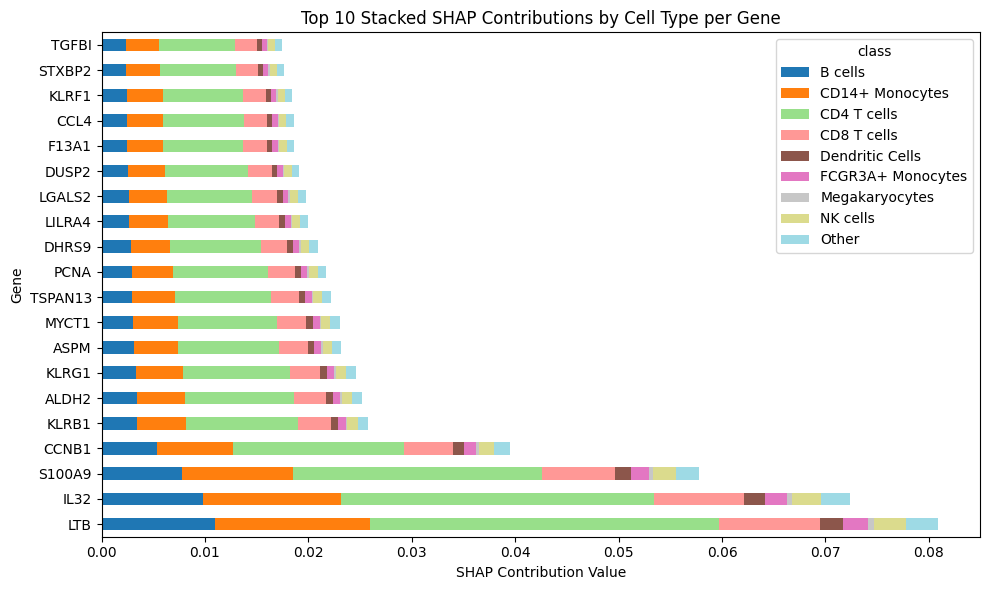

In [31]:
top_n = 20
# Pivot the data so that each group becomes a column for stacking
pivot_df = attributions_class_pos_agg.pivot_table(
    index="gene", columns="class", values="mean_shap", aggfunc="sum"
)

# Sort by the total sum of each feature (sum across all groups)
pivot_df["total"] = pivot_df.sum(axis=1)  # Calculate the total sum for each feature
pivot_df = pivot_df.sort_values(by="total", ascending=False)  # Sort by the total value
pivot_df = pivot_df.head(top_n)  # Select the top 10 features

# Plotting the horizontal stacked bar plot
ax = pivot_df.drop("total", axis=1).plot(
    kind="barh", stacked=True, figsize=(10, 6), colormap="tab20"
)

# Add labels and title
ax.set_xlabel("SHAP Contribution Value")
ax.set_ylabel("Gene")
ax.set_title("Top 10 Stacked SHAP Contributions by Cell Type per Gene")

# Display the plot
plt.tight_layout()
plt.show()

And we can see some overlapping genes from the 2 methods for this specific group of cells

As for SCVI-tools v1.3 Work on SHAP is still in progress: please check back in the next release!